<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im HS 2023.
</p>

## Ziel
Für diese Mini Challenge bearbeite ich das Paper [Vinyals, O., Toshev, A., Bengio, S., & Erhan, D. (2014, November 17). Show and Tell: A Neural Image Caption Generator. arXiv.Org.](https://doi.org/10.48550/arXiv.1411.4555). In diesem Paper wird ein Modell vorgestellt, das Bilder in natürliche Sprache beschreibt (Image Captioning). Es kombiniert Convolutional Neural Networks (CNN) und Long Short-Term Memory Networks (LSTM), wobei der Output des CNN mit den tokenisierten Bildbeschreibungen (Captions) konkatiniert und dann in das LSTM-Netzwerk eingespeist wird. Das Modell wird auf dem Datensatz [Hodosh, M., Young, P., & Hockenmaier, J. (2013, August 30). Flickr8k Dataset.
](http://hockenmaier.cs.illinois.edu/8k-pictures.html) trainiert.

## Setup
Hier werden alle benötigten Bibliotheken importiert und Einstellungen vorgenommen.

In [1]:
# Standard Libraries
import os
import sys
import logging
import warnings

from collections import defaultdict

# 3rd Party Libraries
import matplotlib as mpl
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as li
import torch
import torchmetrics
import torchvision
import wandb

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.text.bleu import BLEUScore
from torchvision import transforms
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Print information about the environment
print("Packages: ")
print(f" | Python Version: {sys.version}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Pandas Version: {pd.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchmetrics Version: {torchmetrics.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"   | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"   | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Settings
torch.set_float32_matmul_precision("high")
nltk.download('punkt')
torch.manual_seed(0)

# Silence warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Final message
print("Setup complete!\n")

Packages: 
 | Python Version: 3.10.13 (main, Aug 24 2023, 12:59:26) [Clang 15.0.0 (clang-1500.0.40.1)]
 | Matplotlib Version: 3.6.3
 | NLTK Version: 3.8.1
 | Numpy Version: 1.23.5
 | Pandas Version: 2.1.1
 | PyTorch Lightning Version: 2.0.2
 | PyTorch Version: 2.1.2
 | Torchmetrics Version: 0.11.4
 | Torchvision Version: 0.15.2
 | Wandb Version: 0.15.3

Backends: 
 | CUDA: False
   | CUDA Built: False
 | MPS: True
   | MPS Built: True

Ressources: 
 | CPU Threads: 8
env: WANDB_SILENT=True
Setup complete!



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabriel.torres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Hier werden alle benötigten Konstanten definiert.

In [2]:
# Files
IMG_PATH = "data/Images"
ANN_FILE = "data/captions.txt"

# Data Module
BATCH_SIZE = 64
NUM_WORKERS = 0 # number of CPU cores - 1 | 0 on Apple Silicon
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Special Tokens
START_TOKEN = "<start>"
END_TOKEN = "<end>"
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
SPECIAL_TOKENS = [START_TOKEN, END_TOKEN, PAD_TOKEN, UNK_TOKEN]

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

Hier wird der Tokenizer definiert. Wir nehmen für diese Mini Challenge den Word Tokenizer `(nltk_word_tokenize)` von NLTK.

In [3]:
tokenizer = nltk_word_tokenize

## Arbeitsschritte

### Schritt 1: Daten 
In diesem Schritt lesen wir die Daten ein und bereiten sie für das Training vor.

Hier finden wir alle verschiedenen Captions für jedes Bild.

In [4]:
# read annotations as df
ann = pd.read_csv(ANN_FILE, sep=",")
ann

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 2 columns]

Hier definieren wir anhand der Daten und des Tokenizers die Vokabulargrösse und die maximale Länge der Captions (mit Start- und Endtoken).

In [5]:
all_tokens_set = set(ann["caption"].apply(tokenizer).explode().tolist())

VOCAB_SIZE = len(all_tokens_set) + len(SPECIAL_TOKENS) 
MAX_CAPTION_LENGTH = ann["caption"].apply(tokenizer).apply(len).max() + 2  # + start & end token

print(f"Vocabulary Size:\t\t\t{VOCAB_SIZE}")
print(f"Max. Number of Tokens in a caption:\t{MAX_CAPTION_LENGTH}")

Vocabulary Size:			9634
Max. Number of Tokens in a caption:	40


Hier erstellen wir ein Vokabular, welches die Tokens in Zahlen umwandelt (und umgekehrt).
Zusätzlich erstellen wir eine Funktion, welches jede Caption mit Start- und Endtoken versieht und diese auf die maximale Länge paddet.

In [6]:
# vocabulary which maps tokens to indices
vocab = {token: idx for idx, token in enumerate(sorted(all_tokens_set))}
for token in SPECIAL_TOKENS:
    vocab[token] = len(vocab)
    
# inverse vocabulary which maps indices to tokens
inv_vocab = {idx: token for token, idx in vocab.items()} # für rücktransformation

# convert tokens str to int, if token not in vocab, use unk_token
def tokens_str_to_int(tokens):
    return [vocab.get(token, vocab[UNK_TOKEN]) for token in tokens] 

# converts tokens int to str, if token not in vocab, use unk_token
def tokens_int_to_str(tokens_idx):
    return [inv_vocab.get(idx, UNK_TOKEN) for idx in tokens_idx]

# converts a string to a list of tokens with the length max_num_tokens
def text_process(text):
    tokenized_text = [START_TOKEN] + tokenizer(text) + [END_TOKEN]
    n_pad = MAX_CAPTION_LENGTH - len(tokenized_text)
    return tokenized_text + n_pad * [PAD_TOKEN]

example_caption = ann["caption"][0]
print(f"Example caption:\n{example_caption}\n")
print(f"Tokenized caption:\n{text_process(example_caption)}\n")
print(f"Tokenized caption (int):\n{tokens_str_to_int(text_process(example_caption))}\n")

Example caption:
A child in a pink dress is climbing up a set of stairs in an entry way .

Tokenized caption:
['<start>', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Tokenized caption (int):
[9630, 68, 2580, 4910, 1240, 6514, 3457, 4995, 2675, 9105, 1240, 7526, 6030, 8185, 4910, 1411, 3665, 9334, 13, 9631, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632, 9632]



Hier definieren wir das Preprocessing der Bilder. Wir skalieren jedes Bild auf 3x224x224.

In [7]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
    ]
)

Hier erstellen wir das DataSet, welches uns die Bilder, die Captions und die umgewandelten Captions (int) zurückgibt.

In [8]:
from PIL import Image
# define dataset
class Flickr8kDataSet(Dataset):
    def __init__(self, ann):
        self.ann = ann.reset_index(drop=True)
        self.unique_images = self.ann["image"].unique()

    def __len__(self):
        return len(self.ann["image"].unique())

    def __getitem__(self, idx):
        # Image 
        image_path = os.path.join(IMG_PATH, self.unique_images[idx])
        image = Image.open(image_path)
        image = transform(image)

        # Tokenized Caption as str
        targets = self.ann[self.ann["image"] == self.unique_images[idx]]["caption"].values
        targets = [text_process(target) for target in targets]
        
        # Tokenized Caption as int
        targets_idx = [tokens_str_to_int(target) for target in targets]
        targets_idx = torch.tensor(targets_idx)

        return image, targets, targets_idx

Hier schauen wir uns ein Beispiel an.

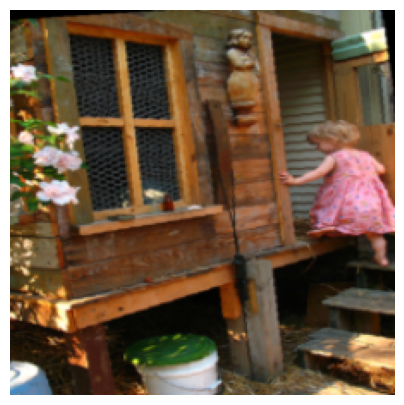

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


In [9]:
def plot_img(image, captions, stringify=True):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    plt.show()
    for caption in captions:
        if stringify:
            print(f"Caption: {' '.join([token for token in caption if token not in SPECIAL_TOKENS])}")
        else:
            print(f"Caption: {caption}")

# get a picture and caption
full_dataset_iter = iter(Flickr8kDataSet(ann))
images, captions, _ = next(full_dataset_iter)
plot_img(images, captions)

Jetzt erstellen wir das DataModule. In diesem werden die Daten geladen, in Train-, Val- und Testset aufgeteilt und die DataLoader erstellt.

In [10]:
class Flickr8kDataModule(li.LightningDataModule):
    def __init__(self):
        super().__init__()
        
    def setup(self, stage=None):
        # split by image
        images = ann.image.unique()
        
        # calculate splitsizes
        n_images = len(images)
        n_val_samples = int(n_images * VAL_RATIO)
        n_test_samples = int(n_images * TEST_RATIO)

        # split
        torch.manual_seed(27112000)
        image_split = random_split(
            images,
            [
                n_images - n_val_samples - n_test_samples,
                n_val_samples,
                n_test_samples,
            ]
        )

        # retrieve image from split
        train_images = images[image_split[0].indices]
        val_images = images[image_split[1].indices]
        test_images = images[image_split[2].indices]
        
        # convert to df for dataset
        train_ann = ann[ann["image"].isin(train_images)]
        val_ann = ann[ann["image"].isin(val_images)]
        test_ann = ann[ann["image"].isin(test_images)]

        # get datasets
        self.train_dataset = Flickr8kDataSet(train_ann)
        self.val_dataset = Flickr8kDataSet(val_ann)
        self.test_dataset = Flickr8kDataSet(test_ann)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

Wir erstellen dieses DataModule und schauen uns ein Beispiel an.

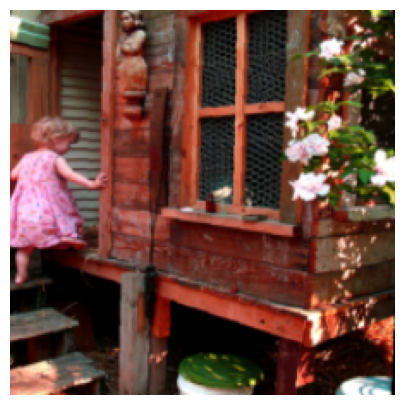

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


In [11]:
flickr8k = Flickr8kDataModule()
flickr8k.setup()

images, captions, caption_tensor = flickr8k.train_dataset[0]
plot_img(images, captions)

Seems to be working :)

### Schritt 2: Aufbau Modellierung 
Hier erstellen wir das Modell. Als Vorbereitung erstellen wir dafür einen `ImageEncoder`, welches die Bilder in numerische Features umwandelt, einen `CaptionEncoder`, welches die Tokens mit den gleichen Dimensionen Embedded und einen `CaptioningDecoder`, welcher das LSTM trainiert und neue Tokens vorhersagt.

Der `ImageEncoder` ist so aufgebaut, dass verschiedene EfficinetNets, ResNets, VGGs und ViTs verwendet werden können. Anstatt den letzten Layer zu trainieren, wird der letzte Layer ersetzt und ein Dropout Layer mit nachfolgendem Linear Layer hinzugefügt. Somit kann Overfitting verhindert werden. Im Paper wird angegeben, dass Dropout das Modell noch besser gemacht hat.

In [12]:
class ImageEncoder(torch.nn.Module):
    def __init__(self, cnn_model, embed_size, p_dropout):
        super().__init__()

        try:
            # load the model
            self.model = torchvision.models.get_model(cnn_model, weights="DEFAULT")

            # freeze all the layers
            for param in self.model.parameters():
                param.requires_grad = False

            # replace the classifier layer on efficientnet
            if cnn_model.startswith("efficientnet"):
                self.model.classifier = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the fc layer on resnet
            elif cnn_model.startswith("resnet"):
                self.model.fc = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.fc.in_features, embed_size),
                )

            # replace the last classifier layer on vgg
            elif cnn_model.startswith("vgg"):
                self.model.classifier[-1] = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.classifier[-1].in_features, embed_size),
                )

            # replace the head layer on vit
            elif cnn_model.startswith("vit"):
                self.model.heads.head = nn.Sequential(
                    nn.Dropout(p=p_dropout),
                    nn.Linear(self.model.heads.head.in_features, embed_size),
                )

            else:
                raise ValueError(f"Transfer Learning on Model {cnn_model} not implemented!")
            
        except Exception as e:
            raise ValueError(f"Cannot load model {cnn_model}!") from e

    def forward(self, x):
        return self.model(x)
    
class CaptionEncoder(torch.nn.Embedding):
    def __init__(self, vocab_size, embed_size):
        # initialize the nn.Embedding base class
        super().__init__(vocab_size, embed_size)

class CaptioningDecoder(torch.nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        
        # define the LSTM layer
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # define the output layer
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input):
        # forward pass
        output, _ = self.lstm(input)
        output = self.linear(output)

        # softmaxing
        return torch.nn.functional.log_softmax(output, dim=-1)

Hier testen wir, ob unsere Encoder und Decoder funktionieren.

In [13]:
# Parameters for testing
cnn_model = "efficientnet_b0" # list of models: torchvision.models.list_models()
embed_size = 400
p_dropout_cnn = 0.2
hidden_size_lstm = 1000
num_layers_lstm = 1

# Test Image Encoder dimensions
img_encoder = ImageEncoder(cnn_model, embed_size, p_dropout_cnn)
img_encoder_out = img_encoder(images.unsqueeze(0))
assert img_encoder(images.unsqueeze(0)).shape[1] == embed_size
print("Image Encoder: OK")
print(f"Image Encoder Output Shape: {img_encoder_out.shape}\n")

# Test Caption Encoder dimensions
cap_encoder = CaptionEncoder(VOCAB_SIZE, embed_size)
cap_encoder_out = cap_encoder(caption_tensor)
assert cap_encoder_out.shape[2] == embed_size
print("Caption Encoder: OK")
print(f"Caption Encoder Output Shape: {cap_encoder_out.shape}\n")

# Print concatenation dimensions
encoded_input = torch.cat((img_encoder_out.unsqueeze(1), cap_encoder_out[0,:,:].unsqueeze(0)), 1)
print(f"Encoded Input Shape: {encoded_input.shape}\n")

# Test Caption Decoder dimensions
cap_decoder = CaptioningDecoder(embed_size, hidden_size_lstm, VOCAB_SIZE, num_layers_lstm)
cap_decoder_out = cap_decoder(encoded_input)
assert cap_decoder_out.shape[2] == VOCAB_SIZE
print("Caption Decoder: OK")
print(f"Caption Decoder Output Shape: {cap_decoder_out.shape}")

Image Encoder: OK
Image Encoder Output Shape: torch.Size([1, 400])

Caption Encoder: OK
Caption Encoder Output Shape: torch.Size([5, 40, 400])

Encoded Input Shape: torch.Size([1, 41, 400])

Caption Decoder: OK
Caption Decoder Output Shape: torch.Size([1, 41, 9634])


Seems to be working :)

Die Encoder und Decoder werden im `ShowAndTell` Modell zusammengeführt. <br>
Hier ist es wichtig anzumerken, dass die `forward` Methode des Modells nur im während dem Training verwendet wird, da beim Vorhersagen die Caption nicht bekannt ist und somit nicht mitgegeben werden kann. Um eine Caption aus nur einem Bild zu generieren, wird die `predict` Methode verwendet.<br>
Auch noch Wissenswert: Bei der `forward` Methode wird automatisch Teacher Forcing verwendet. [Melchior, M. (2023, November 20). Teacher Forcing in PyTorch. Spaces.](https://spaces.technik.fhnw.ch/spaces/deep-learning/beitraege/teacher-forcing-in-pytorch#teacher-forcing-in-pytorch)

In [14]:
class ShowAndTell(li.LightningModule):
    def __init__(self, optimizer, lr, weight_decay, cnn_model, embed_size, p_dropout_cnn, vocab_size, hidden_size_lstm, num_layers_lstm, max_caption_length):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.cnn_model = cnn_model
        self.embed_size = embed_size
        self.p_dropout_cnn = p_dropout_cnn
        self.vocab_size = vocab_size
        self.hidden_size_lstm = hidden_size_lstm
        self.num_layers_lstm = num_layers_lstm
        self.max_caption_length = max_caption_length
        
        # initializing the submodules
        self.img_encoder = ImageEncoder(self.cnn_model, self.embed_size, self.p_dropout_cnn)
        self.caption_encoder = CaptionEncoder(self.vocab_size, self.embed_size)
        self.captioning_decoder = CaptioningDecoder(self.embed_size, self.hidden_size_lstm, self.vocab_size, self.num_layers_lstm)
        
        # loss function 
        self.loss_function = nn.CrossEntropyLoss()

        # metrics
        self.bleu1_metric = BLEUScore(n_gram=1)
        self.bleu2_metric = BLEUScore(n_gram=2)
        self.bleu3_metric = BLEUScore(n_gram=3)
        self.bleu4_metric = BLEUScore(n_gram=4)
        
        # scores and examples
        self.scores = defaultdict(list)
        self.examples = {
            "epoch": [],
            "caption": [],
            "prediction": []
        }
    
    def forward(self, images, captions):
        # encode the images and captions
        embedded_images = self.img_encoder(images).unsqueeze(1)

        # iterate through the captions
        decoded_captions = torch.zeros((captions.shape[1], captions.shape[0], captions.shape[2]+1, self.vocab_size), device=images.device)
        for i, caption in enumerate(captions.permute(1, 0, 2)):
            # encode the captions
            embedded_captions = self.caption_encoder(caption)

            # concatenate the images and captions
            embedded_captions = torch.cat((embedded_images, embedded_captions), 1)

            # decode the captions
            decoded_caption = self.captioning_decoder(embedded_captions)
            decoded_captions[i] = decoded_caption

        # decode the captions
        return decoded_captions
    
    def predict(self, images, max_caption_length=None):
        with torch.no_grad():

            # set the maximum caption length if not specified
            if max_caption_length is None:
                max_caption_length = self.max_caption_length

            # encode the images
            embedded_images = self.img_encoder(images).unsqueeze(1)

            # initialize the caption with the start token
            current_tokens = torch.tensor(tokens_str_to_int([START_TOKEN]), device=images.device)
            current_tokens = current_tokens.repeat(len(images), 1)

            for _ in range(max_caption_length-1):
                # encode the current tokens
                embedded_captions = self.caption_encoder(current_tokens)
                embedded_captions = torch.cat((embedded_images, embedded_captions), 1)
                
                # decode the captions
                output = self.captioning_decoder(embedded_captions).argmax(dim=-1)

                # append the predicted token to the current tokens
                current_tokens = torch.cat((current_tokens, output[:,-1:]), 1)

            return current_tokens
        
    def _step(self, batch, batch_idx):
        # forward pass
        images, _, captions = batch
        outputs = self(images, captions)[:, :, :-1, :] # remove last token, because it is not used as input
        captions = captions.permute(1, 0, 2)
        
        # calculate loss
        loss = self.loss_function(outputs.reshape(-1, VOCAB_SIZE), captions.reshape(-1))

        # return loss
        return loss
    
    def _step_return_results(self, batch, batch_idx):
        # forward pass
        images, captions, captions_int = batch
        outputs = self(images, captions_int)[:, :, :-1, :] # remove last token, because it is not used as input
        captions_int = captions_int.permute(1, 0, 2)
        
        # calculate loss
        loss = self.loss_function(outputs.reshape(-1, VOCAB_SIZE), captions_int.reshape(-1))
        
        # forward pass w/o teacher forcing and wrangling for metrics
        outputs = self.predict(images, MAX_CAPTION_LENGTH)
        outputs = [" ".join([token for token in tokens_int_to_str(caption) if token not in SPECIAL_TOKENS]) for caption in outputs.tolist()]
        captions_ = [[[captions[j][i][k] for i in range(len(captions[0]))] for j in range(len(captions))] for k in range(len(captions[0][0]))]
        captions_ = [[" ".join([token for token in caption if token not in SPECIAL_TOKENS]) for caption in captions] for captions in captions_]
        
        # saving into dict
        predictions = defaultdict(list)
        predictions["images"] = images
        predictions["captions"] = captions_
        predictions["outputs"] = outputs

        # return loss and predictions
        return loss, predictions
            
    def training_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, predictions = self._step_return_results(batch, _)

        bleu1 = self.bleu1_metric(predictions["outputs"], predictions["captions"])
        bleu2 = self.bleu2_metric(predictions["outputs"], predictions["captions"])
        bleu3 = self.bleu3_metric(predictions["outputs"], predictions["captions"])
        bleu4 = self.bleu4_metric(predictions["outputs"], predictions["captions"])

        self.scores['val_loss'].append(loss)
        self.scores['val_BLEU1'].append(bleu1)
        self.scores['val_BLEU2'].append(bleu2)
        self.scores['val_BLEU3'].append(bleu3)
        self.scores['val_BLEU4'].append(bleu4)
        
        # log first example of batch
        self.examples["epoch"].append(self.current_epoch)
        self.examples["caption"].append(predictions["captions"][0][0])
        self.examples["prediction"].append(predictions["outputs"][0])

    def on_validation_epoch_end(self):
        self.log('val_loss',  torch.tensor(self.scores['val_loss']).mean())
        self.log('val_BLEU1', torch.tensor(self.scores['val_BLEU1']).mean())
        self.log('val_BLEU2', torch.tensor(self.scores['val_BLEU2']).mean())
        self.log('val_BLEU3', torch.tensor(self.scores['val_BLEU3']).mean())
        self.log('val_BLEU4', torch.tensor(self.scores['val_BLEU4']).mean())
        self.logger.log_text(key="val_samples", dataframe=pd.DataFrame.from_dict(self.examples))
        
        self.scores = defaultdict(list)

    def test_step(self, batch, _):
        loss, predictions = self._step_return_results(batch, _)
            
        bleu1 = self.bleu1_metric(predictions["outputs"], predictions["captions"])
        bleu2 = self.bleu2_metric(predictions["outputs"], predictions["captions"])
        bleu3 = self.bleu3_metric(predictions["outputs"], predictions["captions"])
        bleu4 = self.bleu4_metric(predictions["outputs"], predictions["captions"])

        self.scores['test_loss'].append(loss)
        self.scores['test_BLEU1'].append(bleu1)
        self.scores['test_BLEU2'].append(bleu2)
        self.scores['test_BLEU3'].append(bleu3)
        self.scores['test_BLEU4'].append(bleu4)
        
    def on_test_epoch_end(self):
        self.log('test_loss',  torch.tensor(self.scores['test_loss']).mean())
        self.log('test_BLEU1', torch.tensor(self.scores['test_BLEU1']).mean())
        self.log('test_BLEU2', torch.tensor(self.scores['test_BLEU2']).mean())
        self.log('test_BLEU3', torch.tensor(self.scores['test_BLEU3']).mean())
        self.log('test_BLEU4', torch.tensor(self.scores['test_BLEU4']).mean())
               
        self.scores = defaultdict(list)

    def configure_optimizers(self):
        # define the optimizer
        match self.optimizer:
            case "SGD":
                return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case "Adam":
                return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay) 
            case "AdamW":
                return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
            case _:
                raise ValueError(f"Optimizer {self.optimizer} not supported!")

Hier machen wir einen Testlauf mit dem Modell, um zu schauen, ob es funktioniert.

In [15]:
model = ShowAndTell(
    optimizer="Adam",
    lr=0.0001,
    weight_decay=0.001,
    cnn_model="efficientnet_b0",
    embed_size=512,
    p_dropout_cnn=0.5,
    vocab_size=VOCAB_SIZE,
    hidden_size_lstm=1000,
    num_layers_lstm=1,
    max_caption_length=MAX_CAPTION_LENGTH,
)

trainer = li.Trainer(
    max_epochs=1,
    log_every_n_steps=1,
    fast_dev_run=2,
    enable_progress_bar=True,
)

trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Das Modell hat beim Testlauf keinen Fehler geworfen. Seems to be working :)

### Schritt 3: Training

Ich optimiere mein Modell jetzt auf folgende Hyperparameter:
- Optimizer: `Adam`
  - SGD wurde zwar im Paper verwendet, gab bei meinen Tests jedoch suboptimale Resultate.
- Lernrate (lr): `0.001` oder `0.0003`
  - Die Lernrate wurde im Paper nicht erwähnt. Da Adam verwendet wird, habe ich kleine Lernraten gewählt.
- L2 Regularisierung (weight_decay): `0.00001`
  - Die L2 Regularisierung wurde im Paper nicht erwähnt. Da ich aber beim CNN bereits Dropout verwende, wähle ich hier einen kleinen Wert.
- CNN Modell: `efficientnet_b0` oder `vgg11` oder `resnet18`
  - Ich will verschiedene Modelle testen, um zu sehen, welches am besten funktioniert. Ich nehme hier die kleinsten Modelle, um keinen zu grossen Rechenaufwand beim Grid Search zu haben. Danach kann ich die grössere Version dieser Architekturen testen.
- Embedding Grösse (embed_size): `512`
  - Diese Embedding Grösse wurde im Paper verwendet, deswegen verwende ich sie auch.
- Dropout Wahrscheinlichkeit (p_dropout_cnn): `0.2` oder `0.5`
  - Hier will ich schwache und starke Regularisierung und deren Auswirkung auf die Generalisierbarkeit des Modells testen.
- LSTM Memory (hidden_size_lstm): `512`
  - Diese Hidden Size wurde im Paper verwendet, deswegen verwende ich sie auch.
- Anzahl der LSTM Layer (num_layers_lstm): `1` oder `2`
  - Im Paper wurden hier keine spezifische Anzahl Layer erwähnt. Hier teste ich den Unterschied zwischen einem und zwei Layer.
- Anzahl Epochen (n_epochs): `30`
  - Hier wähle ich eine etwas grosse Anzahl Epochen, da ich in vorherigen Tests gesehen habe, dass es bis hier am meisten lernt.

Insgesamt haben wir hier 24 verschiedene Modelle, welche wir trainieren.

In [16]:
sweep_config = {
    "method": "grid",
    "name": "ShowAndTell",
    "parameters": {
        "optimizer": {"values": ["Adam"]},
        "lr": {"values": [0.001, 0.0003]},
        "weight_decay": {"values": [0.00001]},
        "cnn_model": {"values": ["efficientnet_b0", "vgg11", "resnet18"]},
        "embed_size": {"values": [512]},
        "p_dropout_cnn": {"values": [0.5, 0.2]},
        "hidden_size_lstm": {"values": [512]},
        "num_layers_lstm": {"values": [1, 2]},
        "n_epochs": {"values": [30]},
    },
}

def train():
    with wandb.init() as run:
        config = run.config
        wandb_logger = li.loggers.WandbLogger(log_model=True)

        model = ShowAndTell(
            optimizer=config.optimizer,
            lr=config.lr,
            weight_decay=config.weight_decay,
            cnn_model=config.cnn_model,
            embed_size=config.embed_size,
            p_dropout_cnn=config.p_dropout_cnn,
            vocab_size=VOCAB_SIZE,
            hidden_size_lstm=config.hidden_size_lstm,
            num_layers_lstm=config.num_layers_lstm,
            max_caption_length=MAX_CAPTION_LENGTH,
        )

        wandb_logger.watch(model)
        trainer = li.Trainer(
            max_epochs=config.n_epochs,
            log_every_n_steps=1,
            logger=wandb_logger,
            fast_dev_run=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )

        trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

In [17]:
#sweep_id = wandb.sweep(sweep_config, project="fhnw-del-mc2")
#wandb.agent(sweep_id, train)
#wandb.finish()

Sweep Ergebnisse:
https://api.wandb.ai/links/gabrieltorresgamez/a9hpsrul

<iframe src="https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/reports/Sweep1--Vmlldzo2MTk0MDgw" style="border:none;height:500px;width:100%"></iframe>

Bei diesem Sweep konnte ich folgende Kenntnisse gewinnen:
- Mit einer Learning Rate von `0.001` fing das Modell an zu Overfitten. Nach wenigen Epochen wurde aber bereits ein sehr tiefer Wert erreicht. Hier muss entweder eine kleinere Lernrate gewählt werden und länger trainiert oder ein früheres Stoppen des Trainings (Early Stopping) werden.
- Beim LSTM gaben Modelle mit `2` Layer schlechtere Resultate als der Modelle mit nur `1` einem Layer. Es sieht so aus, als würde ein zweites Layer zu Overfitting führen.
- Bei der Wahl des CNNs haben alle Modelle in etwa gleich stark performed. Die Differenz zwischen den verschiedenen Modellen war nicht signifikant.
- Die Differenz zwischen einer Dropout Wahrscheinlichkeit von `0.2` und `0.5` war auch nicht signifikant.

Deswegen werde ich für die nächsten Tests folgende Hyperparameter anzupassen:
- Lernrate (lr): `0.001 mit EarlyStopping`
- LSTM Layer (num_layers_lstm): `1`
- CNN Model (cnn_model): `ResNet18 oder grösser`
- Dropout Wahrscheinlichkeit (p_dropout_cnn): `0.5`

In [18]:
# Hier passe ich die neuen Hyperparameter an.
sweep_config = {
    "method": "grid",
    "name": "ShowAndTell2",
    "parameters": {
        "optimizer": {"values": ["Adam"]},
        "lr": {"values": [0.001]},
        "weight_decay": {"values": [0.00001]},
        "cnn_model": {"values": ["resnet18", "resnet152"]},
        "embed_size": {"values": [512]},
        "p_dropout_cnn": {"values": [0.5]},
        "hidden_size_lstm": {"values": [512]},
        "num_layers_lstm": {"values": [1]},
        "n_epochs": {"values": [30]},
    },
}

# Hier füge ich beim Training das Early Stopping hinzu.
def train():
    with wandb.init() as run:
        config = run.config
        wandb_logger = li.loggers.WandbLogger(log_model=True)

        model = ShowAndTell(
            optimizer=config.optimizer,
            lr=config.lr,
            weight_decay=config.weight_decay,
            cnn_model=config.cnn_model,
            embed_size=config.embed_size,
            p_dropout_cnn=config.p_dropout_cnn,
            vocab_size=VOCAB_SIZE,
            hidden_size_lstm=config.hidden_size_lstm,
            num_layers_lstm=config.num_layers_lstm,
            max_caption_length=MAX_CAPTION_LENGTH,
        )

        wandb_logger.watch(model)
        trainer = li.Trainer(
            max_epochs=config.n_epochs,
            log_every_n_steps=1,
            logger=wandb_logger,
            fast_dev_run=False,
            enable_progress_bar=False,
            enable_model_summary=False,
            callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=0)]
        )

        trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

In [19]:
#sweep_id = wandb.sweep(sweep_config, project="fhnw-del-mc2")
#wandb.agent(sweep_id, train)
#wandb.finish()

Sweep Ergebnisse:
https://api.wandb.ai/links/gabrieltorresgamez/x9sixaij

<iframe src="https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/reports/Sweep2--Vmlldzo2MTk0MTQx" style="border:none;height:500px;width:100%"></iframe>

Bei diesem Sweep konnte ich folgende Kenntnisse gewinnen:
- Durch das wenige Rauschen im Validierungsloss funktioniert Early Stopping gut.
- Ein grösseres CNN als Image Encoder führt zu einem besseren Validierungsloss des Captioning Modells, hat aber als Drawback die höhere Inference Zeit. In jeder Iteration hat das Modell mit einem grösseren CNN auch höhere BLEU Scores erreicht.

Beim BLEU-1 Score habe ich festgestellt, dass er sich über die Zeit nicht wesentlich verbessert. Der BLEU-4 Score wird hingegen besser. Da ich während des Trainings der Modelle auch einige Beispielsamples protokolliere, sehe ich, dass die generierten Beschreibungen (Captions) tatsächlich besser werden:

<iframe src="https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/runs/stz160gk?workspace=user-gabrieltorresgamez" style="border:none;height:500px;width:100%"></iframe>

Anfangs erzeugen die Modelle bei den generierten Captions entweder Unsinn oder wiederholen ständig dieselbe Caption. Mit der Zeit werden diese jedoch genauer. Da die Captions recht ähnlich strukturiert sind und viele Wörter fast in jeder Caption vorkommen (wie 'a', 'man', 'woman', 'dog', 'in' usw.), bleibt der BLEU-1 Score hoch, da das Modell diese Muster zuerst erlernt. Der BLEU-4 Score ist jedoch niedriger, weil das Modell noch nicht gelernt hat, wie es die Wörter richtig kombinieren soll. Daher kann man sagen, dass der BLEU-1 Score nicht besonders aussagekräftig ist.

### Schritt 4: Evaluation

In diesem Abschnitt evaluiere ich das beste Modell (tiefster Validierungsloss) vom Training. 

Hier laden wir von wandb das beste Modell.

In [20]:
# Download model as wandb artifact
model_artifact = wandb.Api().artifact('gabrieltorresgamez/fhnw-del-mc2/model-stz160gk:v0', type='model')
model_path = model_artifact.file('./artifacts/best_model')

# Load the weights into the model
model = ShowAndTell.load_from_checkpoint(
    model_path, 
    optimizer="Adam", 
    lr=0.001, 
    weight_decay=0.00001, 
    cnn_model="resnet152", 
    embed_size=512, 
    p_dropout_cnn=0.5, 
    vocab_size=VOCAB_SIZE, 
    hidden_size_lstm=512, 
    num_layers_lstm=1, 
    max_caption_length=MAX_CAPTION_LENGTH,
    map_location=DEVICE
)

Danach lassen wir alle Bilder durch das Modell laufen, generieren die Captions und speichern alles ab.

In [21]:
model.to(DEVICE).eval()

# Predict every image in the test set and save the predictions
predictions = defaultdict(list)
for batch in tqdm(iter(flickr8k.test_dataloader())):
    images, captions, captions_int = batch
    images, caption_int = images.to(DEVICE), captions_int.to(DEVICE)
    
    # forward pass w/o teacher forcing and wrangling for metrics
    outputs = model.predict(images, MAX_CAPTION_LENGTH)
    outputs = [" ".join([token for token in tokens_int_to_str(caption) if token not in SPECIAL_TOKENS]) for caption in outputs.tolist()]
    captions_ = [[[captions[j][i][k] for i in range(len(captions[0]))] for j in range(len(captions))] for k in range(len(captions[0][0]))]
    captions_ = [[" ".join([token for token in caption if token not in SPECIAL_TOKENS]) for caption in captions] for captions in captions_]
        
    # saving
    predictions["images"].append(images)
    predictions["captions"].append(captions_)
    predictions["outputs"].append(outputs)

# Concatenate the predictions
predictions["images"] = torch.cat(predictions["images"])
predictions["captions"] = sum(predictions["captions"], [])
predictions["outputs"] = sum(predictions["outputs"], [])

  0%|          | 0/19 [00:00<?, ?it/s]

Hier berechnen wir alle Metriken.

In [22]:
bleu1 = BLEUScore(n_gram=1)(predictions["outputs"], predictions["captions"])
bleu2 = BLEUScore(n_gram=2)(predictions["outputs"], predictions["captions"])
bleu3 = BLEUScore(n_gram=3)(predictions["outputs"], predictions["captions"])
bleu4 = BLEUScore(n_gram=4)(predictions["outputs"], predictions["captions"])

print(f"Test BLEU-1:\t\t{bleu1:.4f}")
print(f"Test BLEU-2:\t\t{bleu2:.4f}")
print(f"Test BLEU-3:\t\t{bleu3:.4f}")
print(f"Test BLEU-4:\t\t{bleu4:.4f}")

Test BLEU-1:		0.5946
Test BLEU-2:		0.3766
Test BLEU-3:		0.2431
Test BLEU-4:		0.1580


Im Paper wird für den Flickr8k Datensatz ein BLEU-1 Score von 63 (`0.63`) gegeben. Wir haben hier einen etwas tieferen Score von ~59 (`0.5923`) erhalten, was darauf hindeutet, dass unser Modell fast so gut wie das Modell vom Paper performt aber es noch Verbesserungspotenzial gibt. Das ist erstaunlich, vorallem weil wir nur 19 Epochen (11min auf einer NVIDIA RTX 4070ti) trainiert haben.

Ich wollte auch gerne das Modell auf der BLEU-4 Metrik vergleichen, da diese aussagekräftiger ist. Leider wird beim Paper kein BLEU-4 Score für unseren Datensatz angegeben. 

Hier habe ich auch noch einige Verbesserungsvorschläge, welche unser Modell möglicherweise verbessern könnten:
- `Tiefere Lernrate wählen und länger trainieren`
- `Andere Optimizer probieren`
- `Anders Tokenisieren`
- `Grössere Embedding Size`
- `Vortrainierte Embeddings nutzen`
- `Grossschreibung wegnehmen`
- `Beim LSTM eine grössere Hidden Size probieren`
- `Mehr Regularisierung einbauen und länger trainieren`
- `Beam Search implementieren`
- `Weitere ImageEncoders wie z.B. ViT probieren`
- `Attention im CNN implementieren (ShowAttendAndTell)`
- `Mehr Daten nutzen (z.B. Flickr30k)`
- `LSTM mit anderen Architekturen austauschen (z.B. GRU, Transformer)` <- Hier will einen neuen Ansatz testen

### Schritt 5: Neuer Ansatz - GRU
Als neuen Ansatz testen wir noch ein simpleres Modell, da das LSTM schon recht früh overfitted.

Dafür schreiben wir den CaptioningDecoder so um:

In [23]:
class CaptioningDecoderGRU(torch.nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        
        # define the LSTM layer
        self.lstm = torch.nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        
        # define the output layer
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input):
        # forward pass
        output, _ = self.lstm(input)
        output = self.linear(output)

        # softmaxing
        return torch.nn.functional.log_softmax(output, dim=-1)

Testen ihn auf Fehler:

In [24]:
# Parameters for testing
cnn_model = "efficientnet_b0" # list of models: torchvision.models.list_models()
embed_size = 400
hidden_size_gru = 1000
num_layers_gru = 1

# Test Caption Decoder dimensions
cap_decoder = CaptioningDecoder(embed_size, hidden_size_gru, VOCAB_SIZE, num_layers_gru)
cap_decoder_out = cap_decoder(encoded_input)
assert cap_decoder_out.shape[2] == VOCAB_SIZE
print("Caption Decoder: OK")
print(f"Caption Decoder Output Shape: {cap_decoder_out.shape}")

Caption Decoder: OK
Caption Decoder Output Shape: torch.Size([1, 41, 9634])


Und setzen ihn in unser ShowAndTell Modell ein:

In [25]:
class ShowAndTellGRU(ShowAndTell):
    def __init__(self, optimizer, lr, weight_decay, cnn_model, embed_size, p_dropout_cnn, vocab_size, hidden_size_gru, num_layers_gru, max_caption_length):
        super().__init__(optimizer, lr, weight_decay, cnn_model, embed_size, p_dropout_cnn, vocab_size, hidden_size_gru, num_layers_gru, max_caption_length)
        
        self.hidden_size_gru = hidden_size_gru
        self.num_layers_gru = num_layers_gru
        self.captioning_decoder = CaptioningDecoderGRU(self.embed_size, self.hidden_size_gru, self.vocab_size, self.num_layers_gru)

Als Hyperparameterbasis nehmen wir die Parameter des besten LSTM und spielen mit der Lernrate. Um Overfitting zu verhindern, nutzen wir EarlyStopping.

In [26]:
sweep_config = {
    "method": "grid",
    "name": "ShowAndTellGRU",
    "parameters": {
        "optimizer": {"values": ["Adam"]},
        "lr": {"values": [0.001, 0.0003, 0.0001]},
        "weight_decay": {"values": [0.00001]},
        "cnn_model": {"values": ["resnet152"]},
        "embed_size": {"values": [512]},
        "p_dropout_cnn": {"values": [0.5]},
        "hidden_size_gru": {"values": [512]},
        "num_layers_gru": {"values": [1]},
        "n_epochs": {"values": [50]},
    },
}

def train():
    with wandb.init() as run:
        config = run.config
        wandb_logger = li.loggers.WandbLogger(log_model=True)

        model = ShowAndTellGRU(
            optimizer=config.optimizer,
            lr=config.lr,
            weight_decay=config.weight_decay,
            cnn_model=config.cnn_model,
            embed_size=config.embed_size,
            p_dropout_cnn=config.p_dropout_cnn,
            vocab_size=VOCAB_SIZE,
            hidden_size_gru=config.hidden_size_gru,
            num_layers_gru=config.num_layers_gru,
            max_caption_length=MAX_CAPTION_LENGTH,
        )

        wandb_logger.watch(model)
        trainer = li.Trainer(
            max_epochs=config.n_epochs,
            log_every_n_steps=1,
            logger=wandb_logger,
            fast_dev_run=False,
            enable_progress_bar=False,
            enable_model_summary=False,
            callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=0)]
        )

        trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

In [27]:
#sweep_id = wandb.sweep(sweep_config, project="fhnw-del-mc2")
#wandb.agent(sweep_id, train)
#wandb.finish()

Sweep Ergebnisse:
https://api.wandb.ai/links/gabrieltorresgamez/wykrhgoo

<iframe src="https://wandb.ai/gabrieltorresgamez/fhnw-del-mc2/reports/Sweep3--Vmlldzo2NDM0Mzk0" style="border:none;height:500px;width:100%"></iframe>

Erstaunlicherweise führt bei uns das GRU praktisch identischen Ergebnissen wie das LSTM, obwohl es ein simpleres Modell ist. Man kann daraus interpretieren, dass bei unserem Modell nicht der LSTM, sondern das CNN ein Bottleneck ist. 

Um das Modell deutlich zu verbessern, müssten wir ein besseres Image Encoder Modell finden oder die Extraktion der Informationen vom Bild anders implementieren. Hier könnte man von einem Modell mit Panoptischer Bildsegmentierung profitieren.

### Schritt 6: Beispiele beim besten LSTM Modell
Zum Abschluss schauen wir uns noch ein paar Beispiele an von unserem besten LSTM Modell an.
Wir schauen uns dafür die 5 besten und die 5 schlechtesten Predictions anhand der BLEU Metrik an.

Da die BLEU-1 Metrik sehr viele Captions mit einem Score von 1 und die BLEU-4 Metrik sehr viele Captions mit einem Score von 0 verseht, habe ich mich für die BLEU-2 Metrik entschieden, da diese eine gute Balance zwischen den beiden Metriken hat.

In [28]:
predictions["BLEU2"] = []
for index in tqdm(range(len(predictions["captions"]))):
    bleu2 = BLEUScore(n_gram=2)([predictions["outputs"][index]], [predictions["captions"][index]])
    predictions["BLEU2"].append(bleu2.item())

  0%|          | 0/1213 [00:00<?, ?it/s]

Hier extrahieren wir den Index der 5 besten und 5 schlechtesten Captions.

In [29]:
bleu2_scores = torch.tensor(predictions["BLEU2"])

top5_preds, top5_preds_idx = torch.topk(bleu2_scores, 5, largest=True)
bottom5_preds, bottom5_preds_idx = torch.topk(bleu2_scores, 5, largest=False)

#### Die 5 besten Vorhersagen
Hier geben wir die 5 besten Vorhersagen aus.

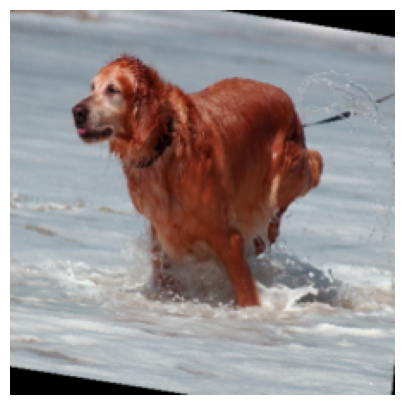

Caption: A brown dog on a leash runs through the white water .
Caption: A soaked dog is playing in the water .
Caption: A tan dog on a leash running in shallow ocean water .
Caption: A wet dog on a leash is running through some water .
Caption: Brown dog running through shallow water .

Prediction: A brown dog is running through the water .
---



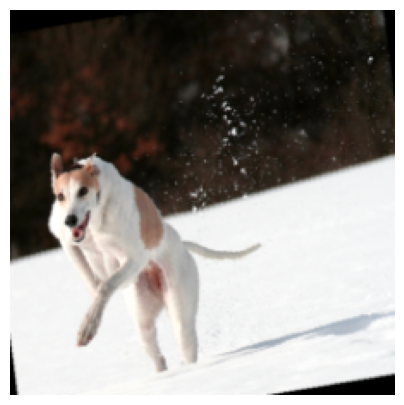

Caption: A brown and white dog is running through the snow .
Caption: A dog is running in the snow
Caption: A dog running through snow .
Caption: a white and brown dog is running through a snow covered field .
Caption: The white and brown dog is running over the surface of the snow .

Prediction: A dog is running through the snow .
---



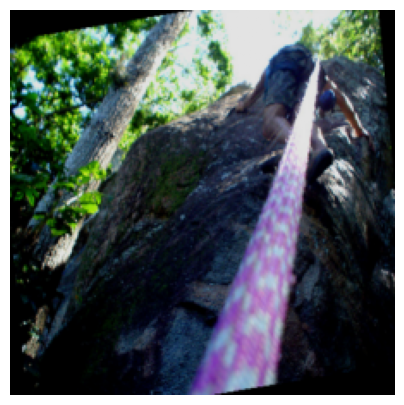

Caption: A climber scales a steep rock face .
Caption: A man is climbing a rope up a cliff .
Caption: A man using a pink rope to climb down a cliff .
Caption: A person is climbing up a rock with a pink rope .
Caption: A person scaling a rocky ledge , with a rope supporting .

Prediction: A person is climbing a rock face .
---



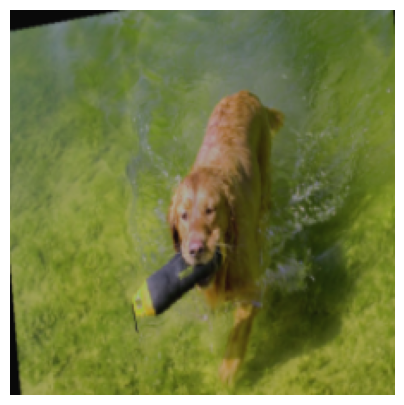

Caption: A brown dog carrying a black object .
Caption: A dog retrieving in the water .
Caption: A dog with a water pack is walking through clear green water .
Caption: The dog is running through the water carrying a black and yellow object in its mouth .
Caption: The Irish Setter is retrieving a flashlight from the pond .

Prediction: A dog is running through the water .
---



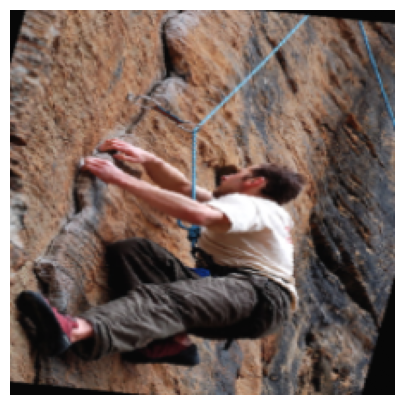

Caption: A man climbing a rock wall
Caption: A man climbing the side of a cliff .
Caption: A man is rock climbing .
Caption: Man with red shoes , white shirt and grey pants climbing .
Caption: The young man with the white t-shirt and jeans is rappeling up the rock wall .

Prediction: A man is rock climbing .
---



In [30]:
for i in top5_preds_idx:
    plot_img(predictions["images"][i].cpu(), predictions["captions"][i], stringify=False)
    print(f"\nPrediction: {predictions['outputs'][i]}")
    print(f"---\n")

Unser Modell scheint Hunde gerne zu mögen. Es kann Bilder mit Hünden sehr gut beschreiben. :)

#### Die 5 schlechtesten Vorhersagen
Hier geben wir die 5 schlechtesten Vorhersagen aus.

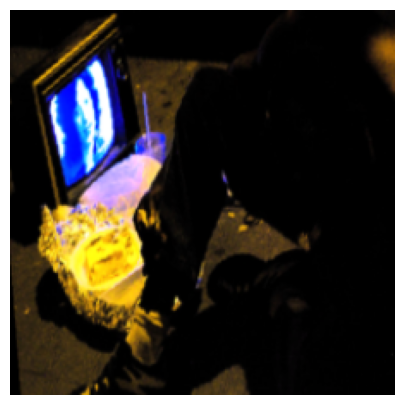

Caption: A person eats takeout while watching a small television .
Caption: A person sits on the floor and eats in front of a television .
Caption: A television with a picture of a girl on it .
Caption: A young man sits on the floor by the television with a fast food meal in front of him .
Caption: Someone is laying in front of the TV eating food .

Prediction: A man in a black shirt and hat is holding a cup .
---



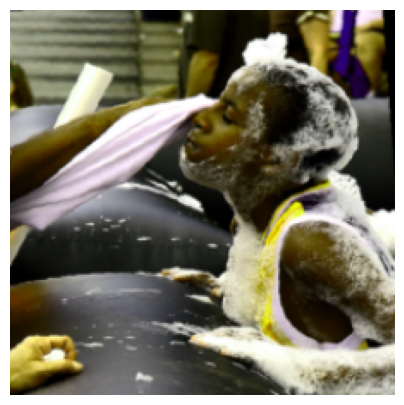

Caption: a boy cleans the bubbles off his face .
Caption: A boy covered in suds has his face wiped clean .
Caption: A boy is covered in bubbles .
Caption: A child covered in foam is climbing on a black inflatable ramp .
Caption: A person covered in soapy water is getting cleaned off .

Prediction: A man in a red shirt is standing in front of a large crowd of people .
---



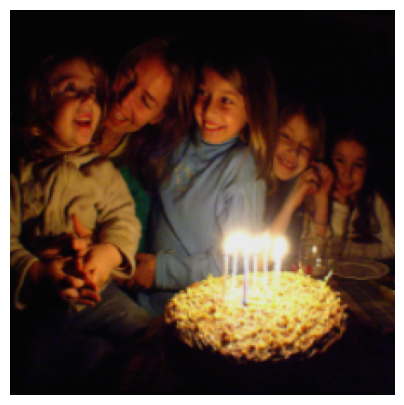

Caption: girls seated at table with a candle covered with lit candles
Caption: A birthday celebration taking place for a girl who has reached age 5 .
Caption: Boy and his family celebrating his birthday with a brightly lit cake .
Caption: Smiling children gathered around a birthday cake
Caption: Woman and four little girls , near cake with candles .

Prediction: A group of people are sitting in a room with their backs to the camera .
---



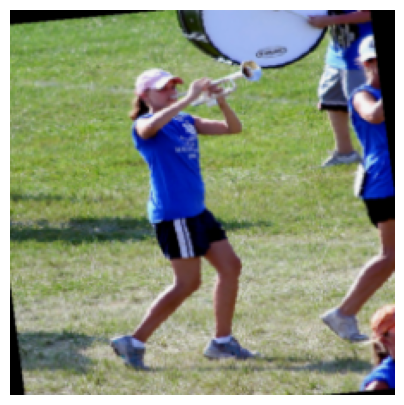

Caption: A girl playing trumpet in a marching band .
Caption: A teenager plays her trumpet on the field at a game .
Caption: a young girl wearing a blue shirt marching in a band playing a trumpet
Caption: Girl playing the trumpet in a marching band
Caption: Girl wearing blue shirt and black shorts plays trumped outside .

Prediction: A group of men play rugby .
---



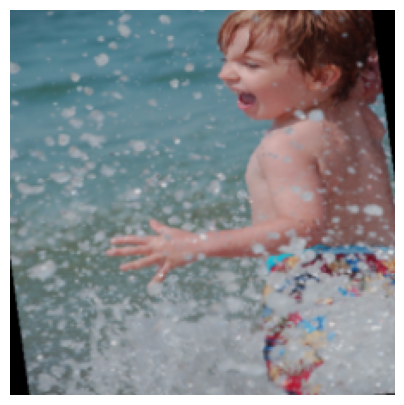

Caption: A little boy stands in the surf .
Caption: A small child wades through the water while being guided by another person .
Caption: A young boy laughs while splashing in the ocean .
Caption: a young boy wearing a colorful bathing suit splashing in the ocean
Caption: A young child splashing in water .

Prediction: A boy in a pool .
---



In [31]:
for i in bottom5_preds_idx:
    plot_img(predictions["images"][i].cpu(), predictions["captions"][i], stringify=False)
    print(f"\nPrediction: {predictions['outputs'][i]}")
    print(f"---\n")

Hier erkennen wir, dass das Modell bei eher unkonventionellen Bildern (z.B. Klettern, schlecht beleuchtete Umgebung, viele Personen) viel Mühe hat. Da wir nur wenige Bilder haben ist dies aber auch verständlich, da das Modell nicht so viele Beispiele hat, um diese Situationen zu lernen. Bei einigen Bildern, bei welchem das Modell schlecht funktioniert kann man jedoch erkennen, dass das Modelle grundlegende Konzepte versteht, jedoch bei den Details Mühe hat. Zum Beispiel verwechselt es "Männer" mit "Knaben", "2 Frauen" mit "einem Mann und einer Frau", "ein Knabe" mit "einem Baby", "ein rotes Shirt" mit "ein blaues Shirt" etc.

### Adversarial Attack

In [32]:
# Download model as wandb artifact
model_artifact = wandb.Api().artifact("gabrieltorresgamez/fhnw-del-mc2/model-ek5r1vp8:v0", type="model")
model_path = model_artifact.file("./artifacts/best_model")

# Load the weights into the model
model = ShowAndTell.load_from_checkpoint(
    model_path,
    optimizer="Adam",
    lr=0.001,
    weight_decay=0.00001,
    cnn_model="resnet18",
    embed_size=512,
    p_dropout_cnn=0.5,
    vocab_size=VOCAB_SIZE,
    hidden_size_lstm=512,
    num_layers_lstm=1,
    max_caption_length=MAX_CAPTION_LENGTH,
    map_location=DEVICE,
)

Top 5 BLEU-2 Score Indices: tensor([49,  0, 72, 59, 17])


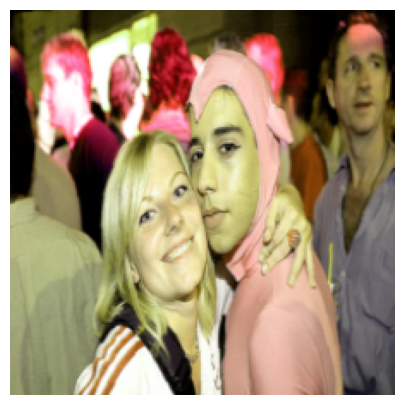

Caption: A blond woman poses with a person in a pink costume .
Caption: A smiling woman holds a person dressed in a pig costume .
Caption: A young woman hugs a young man who 's wearing a pink costume .
Caption: Blond embracing young man in pink costume , at event
Caption: Two people are hugging and one is wearing a pink-hooded stretch top .

Prediction: A group of people are standing together in front of a white building .


In [33]:
print(f"Top 5 BLEU-2 Score Indices: {top5_preds_idx}")

# First image
first_img_idx = 20#top5_preds_idx[2]
plot_img(predictions["images"][first_img_idx].cpu(), predictions["captions"][first_img_idx], stringify=False)
print(f"\nPrediction: {predictions['outputs'][first_img_idx]}")

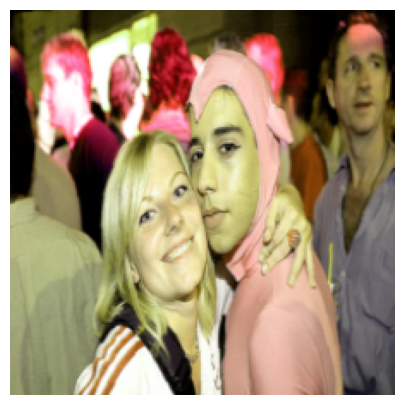

Predicted Label: knot, Certainty: 26.67%
Predicted Label: waffle iron, Certainty: 8.32%
Predicted Label: marimba, Certainty: 4.85%
Predicted Label: oxcart, Certainty: 3.66%
Predicted Label: basketball, Certainty: 3.58%


In [34]:
import requests
# Download cnn model ResNet152
cnn_model_name = "resnet18"
cnn_model = torchvision.models.get_model(cnn_model_name, weights="DEFAULT").to(DEVICE)

# propagate the image through the model
cnn_model.eval()
with torch.no_grad():
    img_features = cnn_model(predictions["images"][first_img_idx].unsqueeze(0))
    img_features = torch.nn.functional.softmax(img_features, dim=1)

# get the labels
labels_url = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
labels = requests.get(labels_url).text.split("\n")

# print the top 5 labels
top5_labels = torch.topk(img_features, 5).indices[0]
plt.figure(figsize=(5, 5))
plt.imshow(predictions["images"][first_img_idx].permute(1,2,0).cpu())
plt.axis("off")
plt.show()
for label in top5_labels:
    print(f"Predicted Label: {labels[label]}, Certainty: {100*img_features[0][label]:.2f}%")

Rogue Label: strawberry
Loss at Iteration 0: 10.66532039642334
Loss at Iteration 10: 0.03657842054963112
Loss at Iteration 20: 0.026868551969528198
Loss at Iteration 30: 0.020503360778093338
Loss at Iteration 40: 0.02109297551214695
Loss at Iteration 50: 0.019002651795744896
Loss at Iteration 60: 0.017346220090985298
Loss at Iteration 70: 0.018059466034173965
Loss at Iteration 80: 0.01816798932850361
Loss at Iteration 90: 0.019114581868052483


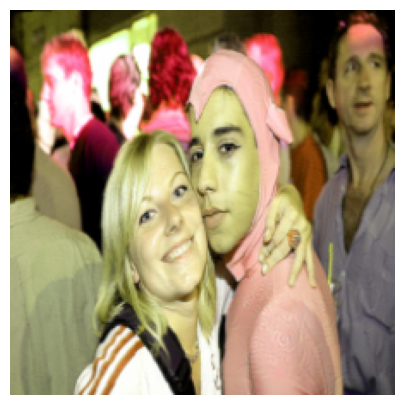

Predicted Label: strawberry, Certainty: 98.35%
Predicted Label: orange, Certainty: 0.34%
Predicted Label: pineapple, Certainty: 0.29%
Predicted Label: manhole cover, Certainty: 0.06%
Predicted Label: wok, Certainty: 0.05%


In [35]:
# rogue label for the image
rogue_label_index = 950
rogue_label = labels[rogue_label_index]
print(f"Rogue Label: {rogue_label}")

# freeze the model
for param in cnn_model.parameters():
    param.requires_grad = False

# create noise tensor
noise = torch.zeros_like(predictions["images"][first_img_idx], requires_grad=True).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam([noise], lr=0.03, weight_decay=0.1)

# define the loss function
loss_function = torch.nn.CrossEntropyLoss()

# iterate
for i in range(100):
    # propagate the image through the model
    img = torch.clamp(predictions["images"][first_img_idx] + noise, 0, 1)
    img_features = cnn_model(img.unsqueeze(0))

    # calculate the loss
    loss = loss_function(img_features, torch.tensor([rogue_label_index]).to(DEVICE))

    # zero the gradients
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # update the noise
    optimizer.step()

    # print the loss
    if i % 10 == 0:
        print(f"Loss at Iteration {i}: {loss.item()}")

img = torch.clamp(predictions["images"][first_img_idx] + noise, 0, 1)
plt.figure(figsize=(5, 5))
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.axis("off")
plt.show()

# propagate the image through the model
with torch.no_grad():
    img_features = cnn_model(img.unsqueeze(0))
    img_features = torch.nn.functional.softmax(img_features, dim=1)

# print the top 5 labels
top5_labels = torch.topk(img_features, 5).indices[0]
for label in top5_labels:
    print(f"Predicted Label: {labels[label]}, Certainty: {100*img_features[0][label]:.2f}%")


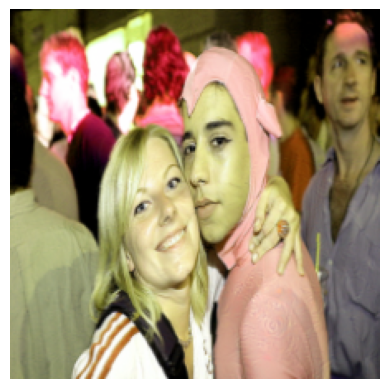

New Prediction:		 A man in a red shirt and a woman in a black dress .
Original Prediction:	 A group of people are standing together in front of a white building .


In [48]:
# propagate the image through the image captioning model
model.eval()
with torch.no_grad():
    caption = model.predict(img.unsqueeze(0), MAX_CAPTION_LENGTH).cpu().numpy()
    caption = " ".join([token for token in tokens_int_to_str(caption[0]) if token not in SPECIAL_TOKENS])


# print the caption
plt.imshow(img.permute(1, 2, 0).detach().cpu())
plt.axis("off")
plt.show()

print(f"New Prediction:\t\t {caption}")
print(f"Original Prediction:\t {predictions['outputs'][first_img_idx]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


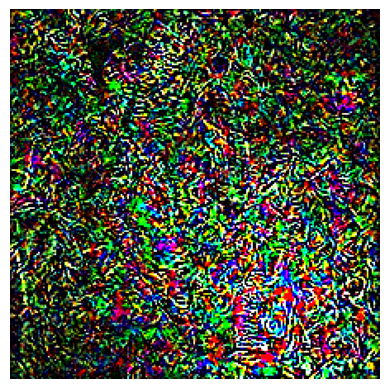

In [52]:
noise_img = torch.clamp(noise, 0, 1) * 255
plt.imshow(noise_img.permute(1, 2, 0).detach().cpu())
plt.axis("off")
plt.show()